In [3]:
import os
import pandas as pd
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt

from PIL import Image
import cv2
import imageio
import random
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

In [4]:
directory = '/content/drive/MyDrive/Omdena_lung_cancer/lung_cancer_data/The IQ-OTHNCCD lung cancer dataset'
categories =['Benign cases', 'Malignant cases', 'Normal cases']

## Check access to data

Benign cases


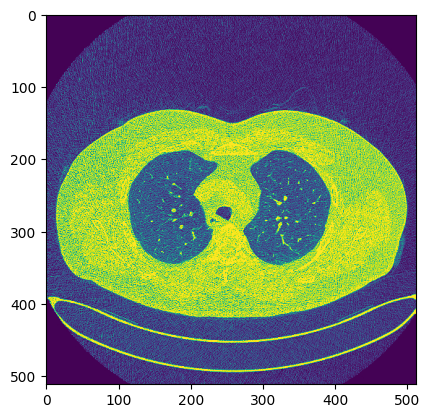

Malignant cases


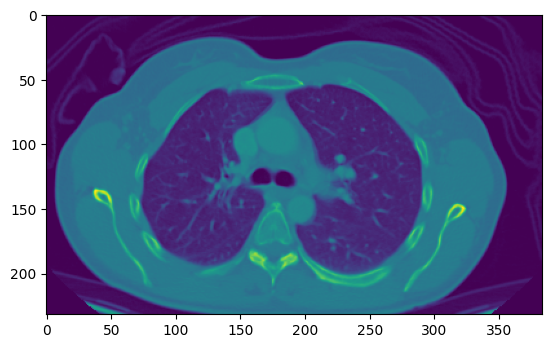

Normal cases


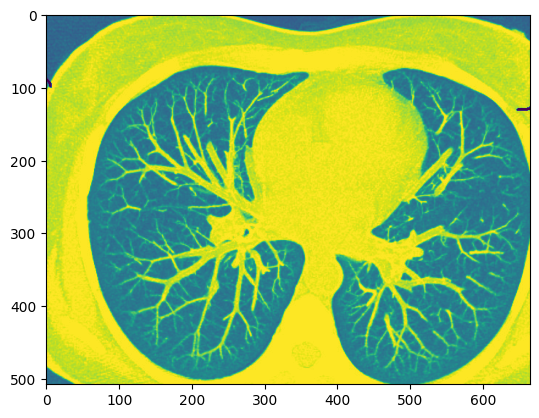

In [5]:
for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        print(i)
        img = cv2.imread(filepath, 0)
        plt.imshow(img)
        plt.show()
        break

In [6]:
for i in categories:
  path = os.path.join(directory, i)
  file_list = os.listdir(path)
  print(len(file_list))

120
1085
577


## Preprocess the data

In [7]:
data = []
img_size = 256

for i in categories:
    path = os.path.join(directory, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)
        # preprocess here
        img = cv2.resize(img, (img_size, img_size))
        data.append([img, class_num])

random.shuffle(data)

In [8]:
X, y = [], []
for feature, label in data:
    X.append(feature)
    y.append(label)

print('X length:', len(X))
print('y counts:', Counter(y))

X length: 1782
y counts: Counter({1: 1085, 2: 577, 0: 120})


In [9]:
# normalize
X = np.array(X).reshape(-1, img_size, img_size, 1)
X = X / 255.0
y = np.array(y)

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=42, test_size=0.3)

In [11]:
print(len(X_train), X_train.shape)
print(len(X_valid), X_valid.shape)

1247 (1247, 256, 256, 1)
535 (535, 256, 256, 1)


## Apply SMOTE to oversample the data

In [12]:
from imblearn.over_sampling import SMOTE

In [13]:
print(len(X_train), X_train.shape)

X_train = X_train.reshape(X_train.shape[0], img_size*img_size*1)

print(len(X_train), X_train.shape)

1247 (1247, 256, 256, 1)
1247 (1247, 65536)


In [14]:
print('Before SMOTE:', Counter(y_train))
smote = SMOTE()
X_train_sampled, y_train_sampled = smote.fit_resample(X_train, y_train)
print('After SMOTE:', Counter(y_train_sampled))

Before SMOTE: Counter({1: 748, 2: 417, 0: 82})
After SMOTE: Counter({1: 748, 2: 748, 0: 748})


In [15]:
X_train = X_train.reshape(X_train.shape[0], img_size, img_size, 1)
X_train_sampled = X_train_sampled.reshape(X_train_sampled.shape[0], img_size, img_size, 1)

print(len(X_train), X_train.shape)
print(len(X_train_sampled), X_train_sampled.shape)

1247 (1247, 256, 256, 1)
2244 (2244, 256, 256, 1)


## Mini-Resnet model

In [16]:
import tensorflow as tf
tf.random.set_seed(42)
import keras

In [17]:
from keras.models import Model
from keras.layers import Input, Dropout, Dense, Flatten, MaxPooling2D, Conv2D
from keras.layers import GlobalAveragePooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.metrics import SparseCategoricalCrossentropy

In [18]:
# convert to rgb images
X_train_rgb = tf.image.grayscale_to_rgb(tf.convert_to_tensor(X_train_sampled))
X_valid_rgb = tf.image.grayscale_to_rgb(tf.convert_to_tensor(X_valid))

print(len(X_train_sampled), X_train_sampled.shape)
print(len(X_train_rgb), X_train_rgb.shape)

2244 (2244, 256, 256, 1)
2244 (2244, 256, 256, 3)


### Mini-Resnet

In [19]:
class IdentityBlock(tf.keras.Model):
  def __init__(self, filters, kernel_size):
    super(IdentityBlock, self).__init__(name='')
    self.conv1 = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')
    self.bn1 = tf.keras.layers.BatchNormalization()
    self.conv2 = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')
    self.bn2 = tf.keras.layers.BatchNormalization()
    self.act = tf.keras.layers.Activation('relu')
    self.add = tf.keras.layers.Add()

  def call(self, input_tensor):
    x = self.conv1(input_tensor)
    x = self.bn1(x)
    x = self.act(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.add([x, input_tensor])
    x = self.act(x)
    return x

In [20]:
class Mini_ResNet(tf.keras.Model):
  def __init__(self):
    super(Mini_ResNet, self).__init__()
    self.conv = tf.keras.layers.Conv2D(64, 5, padding='same')
    self.bn = tf.keras.layers.BatchNormalization()
    self.act = tf.keras.layers.Activation('relu')
    self.max_pool = tf.keras.layers.MaxPool2D(pool_size=(2,2))
    self.id1a = IdentityBlock(64,3)
    self.id1b = IdentityBlock(64,3)
    self.global_pool = tf.keras.layers.GlobalMaxPooling2D()
    self.classifier = tf.keras.layers.Dense(3, activation='softmax')

  def call(self, inputs):
    x = self.conv(inputs)
    x = self.bn(x)
    x = self.act(x)
    x = self.max_pool(x)
    x = self.id1a(x)
    x = self.id1b(x)
    x = self.global_pool(x)
    return self.classifier(x)

In [21]:
model_2 = Mini_ResNet()
model_2.compile(
    # optimizer = 'adam'
    optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=0.001, momentum=0.8),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [22]:
r = model_2.fit(X_train_rgb, y_train_sampled, batch_size=32, epochs=20, validation_data=(X_valid_rgb, y_valid))

Epoch 1/20
71/71 [==============================] - 35s 290ms/step - loss: 1.2034 - accuracy: 0.6395 - val_loss: 2.4591 - val_accuracy: 0.1103
Epoch 2/20
71/71 [==============================] - 17s 246ms/step - loss: 0.4385 - accuracy: 0.8217 - val_loss: 1.4108 - val_accuracy: 0.3514
Epoch 3/20
71/71 [==============================] - 18s 251ms/step - loss: 0.2400 - accuracy: 0.9225 - val_loss: 1.2240 - val_accuracy: 0.4467
Epoch 4/20
71/71 [==============================] - 20s 277ms/step - loss: 0.1811 - accuracy: 0.9421 - val_loss: 0.8368 - val_accuracy: 0.6692
Epoch 5/20
71/71 [==============================] - 19s 272ms/step - loss: 0.1117 - accuracy: 0.9719 - val_loss: 0.5943 - val_accuracy: 0.7308
Epoch 6/20
71/71 [==============================] - 19s 272ms/step - loss: 0.0754 - accuracy: 0.9840 - val_loss: 0.3778 - val_accuracy: 0.8299
Epoch 7/20
71/71 [==============================] - 19s 269ms/step - loss: 0.0533 - accuracy: 0.9902 - val_loss: 0.1602 - val_accuracy: 0.9533

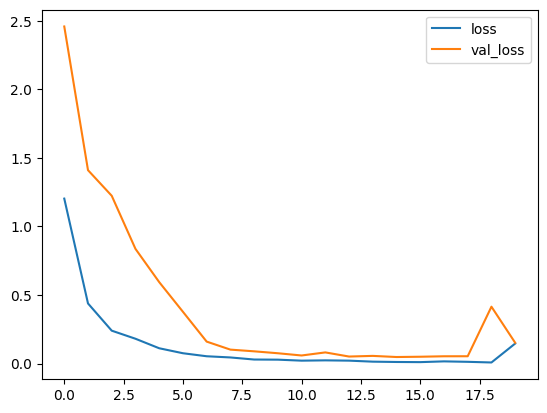

In [23]:
# plot loss per iteration
plt.plot(r.history["loss"], label="loss")
plt.plot(r.history["val_loss"], label="val_loss")
plt.legend()

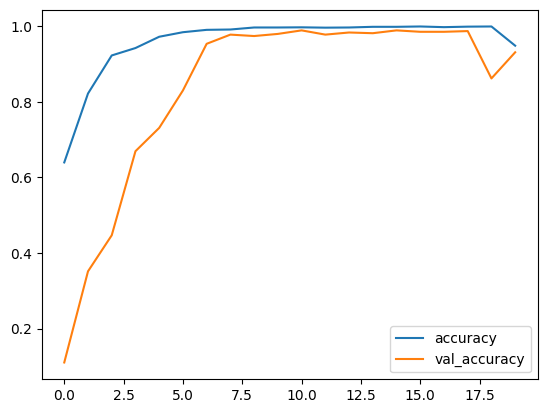

In [24]:
plt.plot(r.history["accuracy"], label="accuracy")
plt.plot(r.history["val_accuracy"], label="val_accuracy")
plt.legend()

In [25]:
!mkdir -p saved_model
model_2.save('saved_model/my_model_2')

In [26]:
new_model_2 = tf.keras.models.load_model('saved_model/my_model_2')

In [27]:
new_model_2.summary()

Model: "mini__res_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  4864      
                                                                 
 batch_normalization (BatchN  multiple                 256       
 ormalization)                                                   
                                                                 
 activation (Activation)     multiple                  0         
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
  (IdentityBlock)            multiple                  74368     
                                                                 
  (IdentityBlock)            multiple                

## Prepare test data

In [28]:
directory_2 = '/content/drive/MyDrive/Omdena_lung_cancer/lung_cancer_data/TEST_DATA'

In [29]:
for i in categories:
  path = os.path.join(directory_2, i)
  file_list = os.listdir(path)
  print(len(file_list))

0
261
54


In [30]:
test_data = []
img_size = 256

for i in categories:
    path = os.path.join(directory_2, i)
    class_num = categories.index(i)
    for file in os.listdir(path):
        filepath = os.path.join(path, file)
        img = cv2.imread(filepath, 0)
        # preprocess here
        img = cv2.resize(img, (img_size, img_size))
        test_data.append([img, class_num])

In [31]:
len(test_data)

315

In [32]:
X_test, y_test = [], []
for feature, label in test_data:
    X_test.append(feature)
    y_test.append(label)

print('X_test length:', len(X_test))
print('y_test length:', len(y_test))

X_test length: 315
y_test length: 315


In [33]:
# normalize
X_test = np.array(X_test).reshape(-1, img_size, img_size, 1)
X_test = X_test / 255.0
y_test = np.array(y_test)

In [34]:
X_test_rgb = tf.image.grayscale_to_rgb(tf.convert_to_tensor(X_test))

## Model evaluation

In [35]:
y_pred = new_model_2.predict(X_test_rgb)

10/10 [==============================] - 2s 158ms/step


In [36]:
y_pred_classes = np.argmax(y_pred, axis=1)

In [37]:
accuracy = accuracy_score(y_test, y_pred_classes)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.9968253968253968


In [38]:
precision = precision_score(y_test, y_pred_classes)
print("Test Precision:", precision)

Test Precision: 0.9961832061068703


In [39]:
recall = recall_score(y_test, y_pred_classes)
print("Test Recall:", recall)

Test Recall: 1.0


In [40]:
cm = confusion_matrix(y_test, y_pred_classes, labels=[1,2])
cm

array([[261,   0],
       [  1,  53]])